In [211]:
from datetime import datetime
from dateutil import parser
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy
import seaborn as sns
import statsmodels.stats.multitest as stats

### preprocessing

In [212]:
input_fp = 'data.csv'

In [213]:
df = pd.read_csv(input_fp)
sites = df['site']
df = df.drop(['site', 'notes'], axis=1)
print(df.shape)
df.head()

(310, 25)


,ISA,karst_features,sinkholes,forest_cover,developed_open_space,time_start,time_lamber_-5hr,Lambert_ppt_mm,lagtime_lambert,time_end_est1,...,q_peak_cms,bf_peak,Area_norm_baseflow_atPeakQ,time_Bfmin,Bfmin,storm_bf_est1,storm_BF_5%_Peak,storm_BF_95_BF_2hr,fil_storm_baseflow,Def_type
0,31.95,145,145,2.19,21.59,4/13/2018 20:45,4/14/2018 0:51,6.32,114.0,4/15/2018 15:35,...,24.890509,0.286436,7.540000e-08,4/14/2018 5:35,0.255642,0.405168,0.393710,0.442997,0.393710,1.0
1,31.95,145,145,2.19,21.59,4/23/2018 4:30,4/22/2018 18:51,5.79,1014.0,4/24/2018 9:45,...,0.730575,0.926702,7.160000e-09,4/24/2018 9:40,0.811402,0.922777,NaN,0.901377,0.901377,1.0
2,31.95,145,145,2.19,21.59,5/6/2018 20:45,5/6/2018 13:00,0.89,550.0,5/7/2018 20:30,...,1.783961,NaN,NaN,NaN,0.850000,NaN,0.859293,0.850985,0.859293,NaN
3,31.95,145,145,2.19,21.59,5/9/2018 7:10,5/7/2018 13:00,0.89,3385.0,NaN,...,1.000000,0.992798,1.050000e-08,0.993588939,0.994113,NaN,0.993589,0.994113,0.993589,NaN
4,31.95,145,145,2.19,21.59,5/14/2018 18:55,5/14/2018 18:51,0.94,119.0,5/16/2018 0:55,...,4.672280,0.461528,2.280000e-08,5/14/2018 20:50,0.461528,0.676622,0.670580,NaN,0.670580,3.0


In [214]:
def get_hourly_difference(t1_datetime_str, t2_datetime_str):
    t1 = parser.parse(t1_datetime_str)
    t2 = parser.parse(t2_datetime_str)
    
    diff = t1 - t2
    
    return float(diff.total_seconds() / 3600)

def isfloat(n):
    try:
        a = float(n)
        return True
    except:
        return False

def transform_temporal_columns(df):
    to_change = ['time_start', 'time_lamber_-5hr', 'time_end_est1', 'time_end_5%peak',
                 'time_Bfmin', 'time_end_95_BF_2hr', 'time_peak']
    changed_dict = {k:[] for k in to_change}
    for i, row in df.iterrows():
        start_time = row['time_start'].strip()
        
        for k in changed_dict.keys():
            if not pd.isna(row[k]) and not isfloat(row[k]):
                time = row[k].strip()
                hours_diff = get_hourly_difference(start_time, time)
                changed_dict[k].append(hours_diff)
            else:
                changed_dict[k].append(row[k])
    
    df = df.drop(to_change, axis=1)
    for column, vals in changed_dict.items():
        df[f'transformed.{column}'] = vals
        
    return df   

In [215]:
df = transform_temporal_columns(df)
df.head()

,ISA,karst_features,sinkholes,forest_cover,developed_open_space,Lambert_ppt_mm,lagtime_lambert,q_peak,5%_peak,q_peak_cms,...,storm_BF_95_BF_2hr,fil_storm_baseflow,Def_type,transformed.time_start,transformed.time_lamber_-5hr,transformed.time_end_est1,transformed.time_end_5%peak,transformed.time_Bfmin,transformed.time_end_95_BF_2hr,transformed.time_peak
0,31.95,145,145,2.19,21.59,6.32,114.0,879.0,43.95,24.890509,...,0.442997,0.393710,1.0,0.0,-4.100000,-42.833333,-28.583333,-8.83333,-124.583333,-6.000000
1,31.95,145,145,2.19,21.59,5.79,1014.0,25.8,1.29,0.730575,...,0.901377,0.901377,1.0,0.0,9.650000,-29.250000,NaN,-29.1667,NaN,-7.250000
2,31.95,145,145,2.19,21.59,0.89,550.0,63.0,3.15,1.783961,...,0.850985,0.859293,NaN,0.0,7.750000,-23.750000,-50.916667,NaN,-42.333333,-1.416667
3,31.95,145,145,2.19,21.59,0.89,3385.0,12.6,0.63,1.000000,...,0.994113,0.993589,NaN,0.0,42.166667,NaN,-43.250000,0.993588939,-29.583333,-14.250000
4,31.95,145,145,2.19,21.59,0.94,119.0,165.0,8.25,4.672280,...,NaN,0.670580,3.0,0.0,0.066667,-30.000000,-22.333333,-1.91667,NaN,-1.916667


In [216]:
def input_missing_values(df):
    X = df.values
    imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
    imputer.fit(X)
    X = imputer.transform(X)
    
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    df = pd.DataFrame(data=X, columns=df.columns)
    return df

In [217]:
df = input_missing_values(df)
df.head()

,ISA,karst_features,sinkholes,forest_cover,developed_open_space,Lambert_ppt_mm,lagtime_lambert,q_peak,5%_peak,q_peak_cms,...,storm_BF_95_BF_2hr,fil_storm_baseflow,Def_type,transformed.time_start,transformed.time_lamber_-5hr,transformed.time_end_est1,transformed.time_end_5%peak,transformed.time_Bfmin,transformed.time_end_95_BF_2hr,transformed.time_peak
0,0.776527,2.590606,2.589757,-0.999374,0.419415,1.414953,-0.993653,1.640671,1.646575,1.663666,...,-3.720224e+00,-1.900811,-0.818212,0.0,-0.232710,-0.103559,1.532891e-02,-1.561577e-01,-1.636208,0.076948
1,0.776527,2.590606,2.589757,-0.999374,0.419415,1.172380,0.261397,-0.417188,-0.427487,-0.412022,...,1.472380e+00,0.720021,-0.818212,0.0,0.068629,0.257498,-1.625005e-16,-7.327603e-01,0.000000,-0.074987
2,0.776527,2.590606,2.589757,-0.999374,0.419415,-1.070273,-0.385651,-0.327465,-0.337057,-0.321520,...,9.015288e-01,0.502764,0.000000,0.0,0.026990,0.403692,-1.006194e+00,2.518652e-17,1.094512,0.634043
3,0.776527,2.590606,2.589757,-0.999374,0.419415,-1.070273,3.567757,-0.449026,-0.459575,-0.388874,...,2.522904e+00,1.196065,0.000000,0.0,0.781252,0.000000,-6.555219e-01,1.225093e-01,1.517816,-0.925824
4,0.776527,2.590606,2.589757,-0.999374,0.419415,-1.047389,-0.986681,-0.081448,-0.089103,-0.073372,...,1.257679e-15,-0.471466,1.085644,0.0,-0.141395,0.237562,3.012028e-01,3.998172e-02,0.000000,0.573269


### PCA

In [247]:
pca = PCA(n_components=5)

In [248]:
decomposed = pca.fit_transform(df.values)

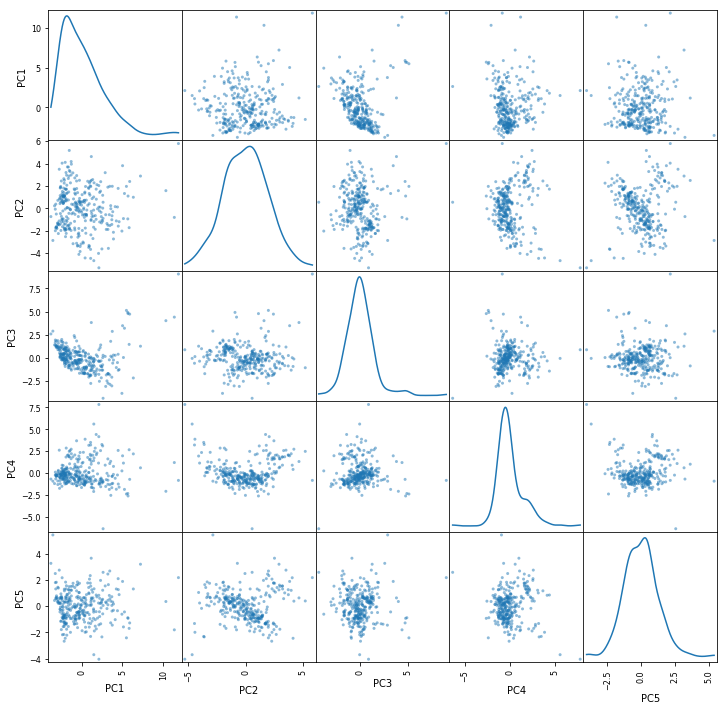

In [249]:
plotting_df = pd.DataFrame(data=decomposed, columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5'])
axs = pd.plotting.scatter_matrix(plotting_df, figsize=(12,12), diagonal='kde')

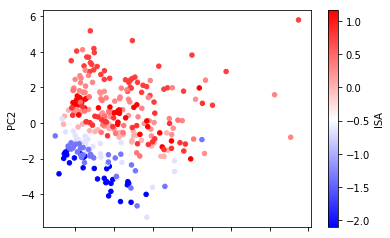

In [224]:
plotting_df['ISA'] = df['ISA']
plotting_df.plot.scatter('PC1', 'PC2', c='ISA', colormap='bwr')

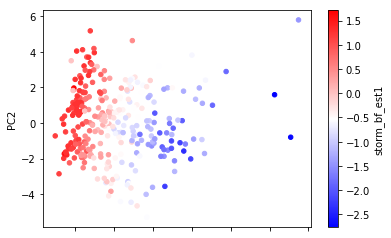

In [225]:
plotting_df['storm_bf_est1'] = df['storm_bf_est1']
plotting_df.plot.scatter('PC1', 'PC2', c='storm_bf_est1', colormap='bwr')

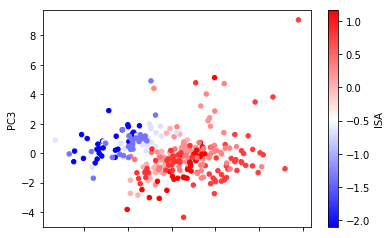

In [226]:
plotting_df.plot.scatter('PC2', 'PC3', c='ISA', colormap='bwr')

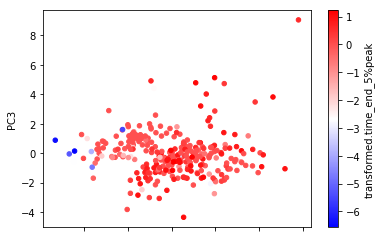

In [252]:
plotting_df['transformed.time_end_5%peak'] = df['transformed.time_end_5%peak']
plotting_df.plot.scatter('PC2', 'PC3', c='transformed.time_end_5%peak', colormap='bwr')

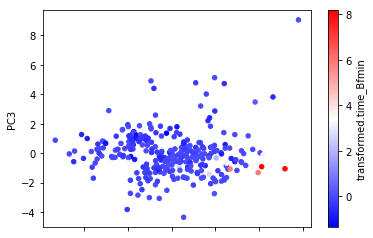

In [253]:
plotting_df['transformed.time_Bfmin'] = df['transformed.time_Bfmin']
plotting_df.plot.scatter('PC2', 'PC3', c='transformed.time_Bfmin', colormap='bwr')

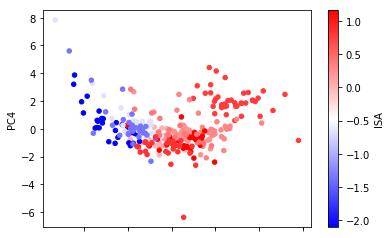

In [227]:
plotting_df.plot.scatter('PC2', 'PC4', c='ISA', colormap='bwr')

In [228]:
feature_importance_tups = zip(df.columns, pca.components_[0, :])
feature_importance_tups = sorted(feature_importance_tups, key=lambda x:x[1])
feature_importance_tups

[('storm_bf_est1', -0.3534509984904648),
 ('fil_storm_baseflow', -0.34964892798001923),
 ('Bfmin', -0.3164295159975875),
 ('bf_peak', -0.2604594620512226),
 ('storm_BF_5%_Peak', -0.24572275283049078),
 ('Def_type', -0.19989316326728399),
 ('storm_BF_95_BF_2hr', -0.19570546249247914),
 ('transformed.time_end_95_BF_2hr', -0.10794886501496723),
 ('forest_cover', -0.09839274020475969),
 ('lagtime_lambert', -0.08468295698604718),
 ('transformed.time_end_est1', -0.08020411756228803),
 ('transformed.time_peak', -0.07091414193644478),
 ('transformed.time_lamber_-5hr', -0.06537888648143403),
 ('transformed.time_Bfmin', -0.032776419802718344),
 ('transformed.time_start', 1.925929944387236e-34),
 ('transformed.time_end_5%peak', 0.010349777091451323),
 ('karst_features', 0.06705155188809217),
 ('developed_open_space', 0.06824512639525546),
 ('sinkholes', 0.06971706459948658),
 ('ISA', 0.1001278761545133),
 ('Lambert_ppt_mm', 0.15283913722382828),
 ('Area_norm_baseflow_atPeakQ', 0.2339511114689455)

In [229]:
feature_importance_tups = zip(df.columns, pca.components_[1, :])
feature_importance_tups = sorted(feature_importance_tups, key=lambda x:x[1])
feature_importance_tups

[('forest_cover', -0.43433423435636453),
 ('Lambert_ppt_mm', -0.1231201972843154),
 ('Def_type', -0.08673705164346633),
 ('transformed.time_lamber_-5hr', -0.04327479739753531),
 ('lagtime_lambert', -0.012181054663063452),
 ('transformed.time_start', 6.310887241768095e-30),
 ('Area_norm_baseflow_atPeakQ', 0.05120182000384437),
 ('storm_BF_95_BF_2hr', 0.10849962412393548),
 ('Bfmin', 0.1199328863464632),
 ('q_peak_cms', 0.1199389787059447),
 ('storm_bf_est1', 0.1223408817458539),
 ('q_peak', 0.12305365591045746),
 ('5%_peak', 0.12399328565205586),
 ('fil_storm_baseflow', 0.13357832451969143),
 ('transformed.time_end_95_BF_2hr', 0.13430424286948273),
 ('transformed.time_end_est1', 0.14302333135420664),
 ('storm_BF_5%_Peak', 0.1666402859448959),
 ('transformed.time_peak', 0.1773125119694415),
 ('bf_peak', 0.17841542558276657),
 ('transformed.time_Bfmin', 0.1831642689260205),
 ('transformed.time_end_5%peak', 0.20180305360627082),
 ('karst_features', 0.3148117673839805),
 ('sinkholes', 0.325

In [246]:
feature_importance_tups = zip(df.columns, pca.components_[3, :])
feature_importance_tups = sorted(feature_importance_tups, key=lambda x:x[1])
feature_importance_tups

[('transformed.time_Bfmin', -0.4551171747404774),
 ('transformed.time_end_5%peak', -0.3649107350198937),
 ('transformed.time_peak', -0.32725636478423004),
 ('Area_norm_baseflow_atPeakQ', -0.14972989894081662),
 ('ISA', -0.09240337411329749),
 ('bf_peak', -0.07476029835990905),
 ('transformed.time_end_est1', -0.06229778468978871),
 ('storm_BF_95_BF_2hr', -0.05364097769241652),
 ('q_peak', -0.043546712289489725),
 ('5%_peak', -0.040280689557372545),
 ('q_peak_cms', -0.03481781468214585),
 ('forest_cover', -0.024298533906101698),
 ('transformed.time_lamber_-5hr', -1.0587911840678754e-22),
 ('Def_type', 0.014477786399219754),
 ('developed_open_space', 0.044333461746305626),
 ('lagtime_lambert', 0.05771894290436234),
 ('fil_storm_baseflow', 0.061394223147727495),
 ('storm_bf_est1', 0.06394869228274336),
 ('Lambert_ppt_mm', 0.06614042826569917),
 ('Bfmin', 0.08051387676069169),
 ('storm_BF_5%_Peak', 0.11214515985938202),
 ('transformed.time_end_95_BF_2hr', 0.11235094268579561),
 ('sinkholes'

### TSNE

In [235]:
tsne = TSNE(n_components=2, perplexity=30)
tsne_decomposed = tsne.fit_transform(df.values)

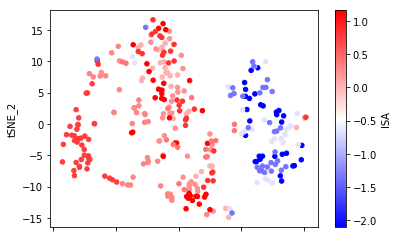

In [236]:
plotting_df = pd.DataFrame(data=tsne_decomposed, columns=['tSNE_1', 'tSNE_2'])
plotting_df['ISA'] = df['ISA']
plotting_df.plot.scatter('tSNE_1', 'tSNE_2', c='ISA', colormap='bwr')

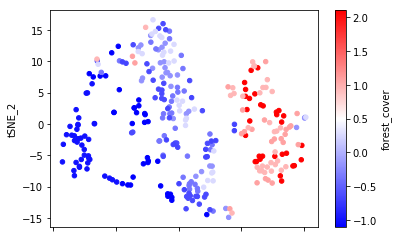

In [237]:
plotting_df['forest_cover'] = df['forest_cover']
plotting_df.plot.scatter('tSNE_1', 'tSNE_2', c='forest_cover', colormap='bwr')

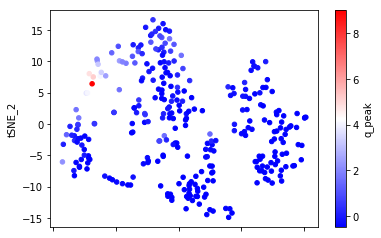

In [238]:
plotting_df['q_peak'] = df['q_peak']
plotting_df.plot.scatter('tSNE_1', 'tSNE_2', c='q_peak', colormap='bwr')

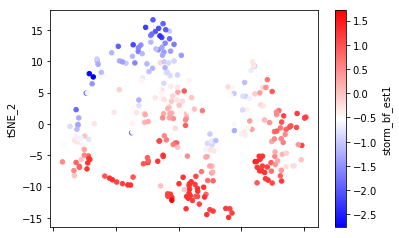

In [239]:
plotting_df['storm_bf_est1'] = df['storm_bf_est1']
plotting_df.plot.scatter('tSNE_1', 'tSNE_2', c='storm_bf_est1', colormap='bwr')

### correlations

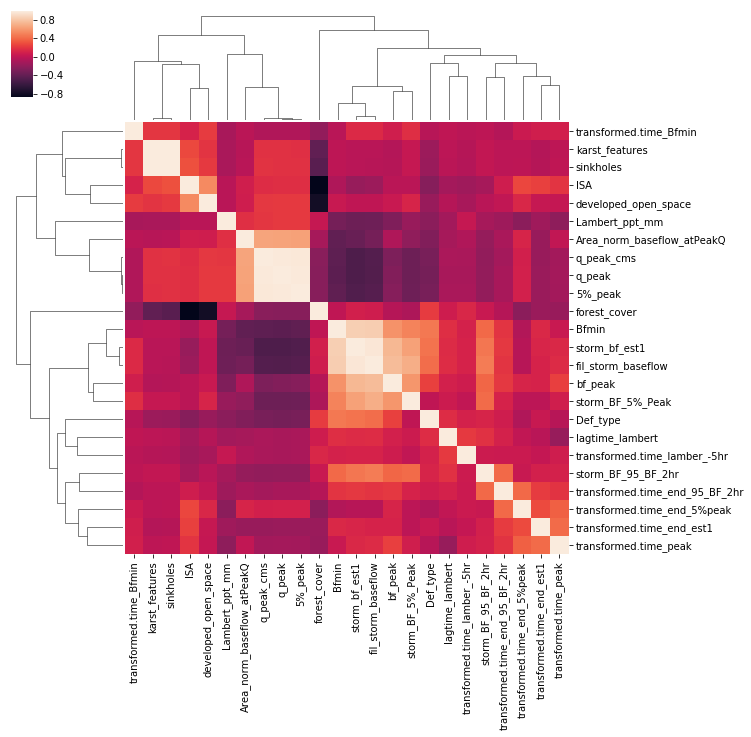

In [240]:
# trash nan start time - its the same for everyone
df = df.drop(['transformed.time_start'], axis=1)
axs = sns.clustermap(df.corr())

In [192]:
x = list(df['karst_features'])
y = list(df['sinkholes'])
scipy.stats.spearmanr(x, y)

SpearmanrResult(correlation=0.868525981343559, pvalue=6.76538407716467e-96)

In [241]:
x = list(df['ISA'])
y = list(df['forest_cover'])
scipy.stats.spearmanr(x, y)

SpearmanrResult(correlation=-0.658443873581227, pvalue=6.6690181992822555e-40)

In [242]:
x = list(df['ISA'])
y = list(df['transformed.time_end_5%peak'])
scipy.stats.spearmanr(x, y)

SpearmanrResult(correlation=0.3166791449523623, pvalue=1.1940800409137848e-08)

In [243]:
dependent_variable = 'ISA'

x = list(df[dependent_variable])

p_values = []
variable_names = [c for c in df.columns
                 if c != dependent_variable]
for c in variable_names:
    p_values.append(scipy.stats.spearmanr(x, list(df[c]))[1])
    
corrected_p_values = stats.fdrcorrection(p_values)

feature_p_value_tups = zip(variable_names, corrected_p_values[1])

In [244]:
sorted(list(feature_p_value_tups), key=lambda x: x[1])

[('forest_cover', 1.5338741858349188e-38),
 ('developed_open_space', 9.618895576435482e-32),
 ('transformed.time_peak', 4.038880122025197e-11),
 ('transformed.time_end_est1', 2.189066713619725e-10),
 ('transformed.time_end_5%peak', 5.4927681882034104e-08),
 ('Def_type', 0.00023172672571398692),
 ('sinkholes', 0.007772061201246501),
 ('transformed.time_Bfmin', 0.007852499926376509),
 ('storm_bf_est1', 0.03930317365838059),
 ('q_peak', 0.04023491653088238),
 ('5%_peak', 0.04627956564113324),
 ('q_peak_cms', 0.04627956564113324),
 ('lagtime_lambert', 0.06817635639180472),
 ('Area_norm_baseflow_atPeakQ', 0.07851266095580708),
 ('fil_storm_baseflow', 0.08380470286185746),
 ('storm_BF_95_BF_2hr', 0.10828266843404026),
 ('Bfmin', 0.4419324093357182),
 ('transformed.time_lamber_-5hr', 0.5135037149837922),
 ('transformed.time_end_95_BF_2hr', 0.8990433790122857),
 ('karst_features', 0.9216759888361125),
 ('storm_BF_5%_Peak', 0.9216759888361125),
 ('Lambert_ppt_mm', 0.9892447925137737),
 ('bf_pea